## Testing Network Robustness

### Definition and Importance

**Network robustness** refers to a network's ability to maintain its functionality when subjected to failures or attacks. It's a critical property in many real-world systems:

- **Internet infrastructure**: Ability to maintain connectivity when routers fail
- **Power grids**: Resilience against cascading failures
- **Transportation networks**: Functionality when roads/airports close
- **Biological networks**: Organism survival when genes/proteins are knocked out
- **Social networks**: Information flow when key individuals are removed

### Network Topologies and Their Robustness Characteristics

Different network structures exhibit distinct robustness profiles. Understanding these fundamental differences is crucial for analyzing vulnerability and designing resilient systems:

- **Scale-free networks**: 
  - Characterized by a power-law degree distribution (P(k) ~ k^-γ)
  - Structure: A few hubs have many connections, while most nodes have few links
  - Examples: Internet, protein interaction networks, citation networks
  - Robustness profile: Highly resistant to random failures but vulnerable to targeted attacks on hubs
  - Diameter behavior: Remains small even as the network grows ("small-world" property), but increases dramatically when hubs are removed

- **Random networks (Erdős–Rényi)**:
  - Characterized by a Poisson degree distribution
  - Structure: Most nodes have approximately the same number of connections (close to the average degree)
  - Examples: Some social networks, random molecular interactions
  - Robustness profile: Moderate and similar vulnerability to both random failures and targeted attacks
  - Diameter behavior: Grows logarithmically with network size and degrades more gradually during node removal

- **Regular lattices and small-world networks**:
  - More uniform structure with similar vulnerability profiles for both random and targeted disruptions
  - Small-world networks combine lattice structure with shortcuts, improving robustness

The key distinction between scale-free and random networks lies in their centrality distribution. Scale-free networks have highly heterogeneous centrality, with a small number of nodes having disproportionate importance, creating a "robust-yet-fragile" property. Random networks have more homogeneous centrality and show more uniform degradation patterns.

### Types of Network Disruption

We consider two primary types of network disruption:

1. **Random Failure**: Nodes fail randomly due to natural causes
   - Examples: Random hardware failures, natural disasters, random mutations
   - Mathematical model: Nodes are removed uniformly at random

2. **Targeted Attack**: Nodes are deliberately removed based on their importance
   - Examples: Strategic attacks on hubs, intentional removal of influential individuals
   - Mathematical model: Nodes are removed in descending order of centrality (degree, betweenness, etc.)

### Measuring Robustness

To quantify network damage, we focus on:

- **Size of Giant Component**: The fraction of nodes that remain in the largest connected component
- **Connectivity**: How quickly the network fragments into disconnected components
- **Path Length**: How much longer paths become after node removal

Let's explore these concepts through simulations:

In [24]:
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

In [25]:
# Create a scale-free network using the Barabási-Albert model
# This type of network is ideal for demonstrating robustness concepts
G = nx.barabasi_albert_graph(100, 3, seed=42)  # 100 nodes, each new node connects to 3 existing nodes
print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph created with 100 nodes and 291 edges.


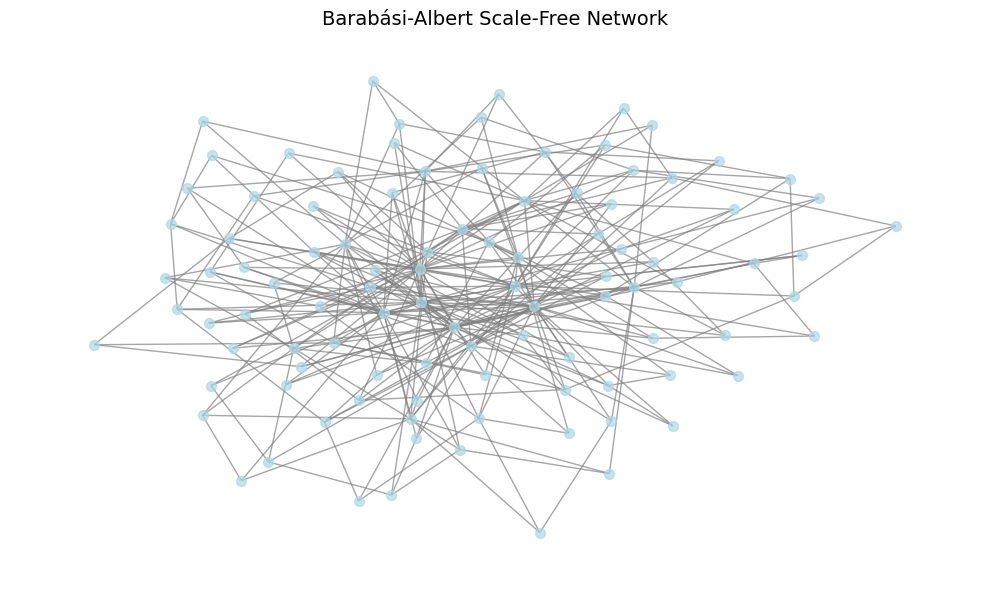

In [26]:
# Visualize the network
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)  # Use a consistent layout with a fixed seed
nx.draw_networkx(G, pos, node_size=50, node_color='lightblue', edge_color='gray', 
        alpha=0.7, with_labels=False)
plt.title('Barabási-Albert Scale-Free Network', fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

### Connected Components Analysis

In order to measure network "damage," we'll track the size of the network's largest connected component (also called the giant component or core). A connected component is a subgraph where there exists a path between any pair of nodes.

As nodes are removed, the network may fragment into multiple disconnected components, with the giant component shrinking in size. The rate of this shrinkage reveals the network's vulnerability to different types of attacks.

Let's explore NetworkX's tools for analyzing connected components:

In [27]:
core = max(nx.connected_components(G), key=len)
core

{0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99}

In [28]:
def simulate_network_attack(G, attack_type='random', removal_fraction=0.5, steps=20):
    """Simulate network attack by progressively removing nodes and measuring robustness.
    
    Parameters:
    -----------
    G : networkx.Graph
        Input network to attack
    attack_type : str
        'random' for random failures, 'targeted' for hub-targeted attacks
    removal_fraction : float
        Fraction of nodes to remove (0 to 1)
    steps : int
        Number of measurement points
    
    Returns:
    --------
    tuple (fractions_removed, giant_component_sizes)
        Arrays containing the fraction of nodes removed and relative size of giant component
    """
    import networkx as nx
    import numpy as np
    import copy
    
    # Make a copy of the graph to avoid modifying the original
    H = copy.deepcopy(G)
    n_original = H.number_of_nodes()
    
    # Calculate how many nodes to remove in total
    total_to_remove = int(n_original * removal_fraction)
    nodes_per_step = max(1, total_to_remove // steps)
    
    # Track results
    fractions_removed = []
    giant_component_sizes = []
    
    # Get the initial giant component size
    largest_cc = max(nx.connected_components(H), key=len)
    giant_component_sizes.append(len(largest_cc) / n_original)
    fractions_removed.append(0.0)
    
    # Remove nodes progressively
    nodes_removed = 0
    
    for i in range(steps):
        if H.number_of_nodes() <= 1 or nodes_removed >= total_to_remove:
            break
            
        # Select nodes to remove in this step
        nodes_to_remove_count = min(nodes_per_step, H.number_of_nodes() - 1, 
                                   total_to_remove - nodes_removed)
        
        if attack_type == 'random':
            # Random failure - select nodes randomly
            node_list = list(H.nodes())
            nodes_to_remove = np.random.choice(node_list, 
                                              size=nodes_to_remove_count, 
                                              replace=False)
        else:
            # Targeted attack - select highest degree nodes
            degree_dict = dict(H.degree())
            sorted_nodes = sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)
            nodes_to_remove = [node for node, _ in sorted(degree_dict.items(), key=lambda x: x[1], reverse=True)[:nodes_to_remove_count]]
        
        # Remove the selected nodes
        H.remove_nodes_from(nodes_to_remove)
        nodes_removed += len(nodes_to_remove)
        
        # Calculate giant component size if the graph is not empty
        if H.number_of_nodes() > 0:
            largest_cc = max(nx.connected_components(H), key=len)
            giant_component_sizes.append(len(largest_cc) / n_original)
            fractions_removed.append(nodes_removed / n_original)
    
    return np.array(fractions_removed), np.array(giant_component_sizes)

## Comparative Analysis: Scale-Free vs. Random Networks

In this section, we'll conduct a systematic comparison of how scale-free and random networks respond to different types of attacks. This analysis will help us visualize and quantify the differences in robustness profiles between these network topologies.

### 1. Setup for Network Comparison

Let's initialize our environment with consistent random seeds to ensure reproducible results.

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

In [30]:
# Create networks with similar properties
n_nodes = 500  # Number of nodes
avg_degree = 6  # Average degree

# Create a scale-free network (Barabási-Albert model)
# In BA model, each node connects to m existing nodes, giving average degree approximately 2m
sf_network = nx.barabasi_albert_graph(n_nodes, m=avg_degree//2, seed=42)

# Create a random network (Erdős-Rényi model)
# To get average degree k in ER model with n nodes, we need probability p = k/(n-1)
er_network = nx.erdos_renyi_graph(n_nodes, p=avg_degree/(n_nodes-1), seed=42)

# Print network statistics
print(f"Scale-free network: {sf_network.number_of_nodes()} nodes, {sf_network.number_of_edges()} edges")
print(f"Random network: {er_network.number_of_nodes()} nodes, {er_network.number_of_edges()} edges")

Scale-free network: 500 nodes, 1491 edges
Random network: 500 nodes, 1489 edges


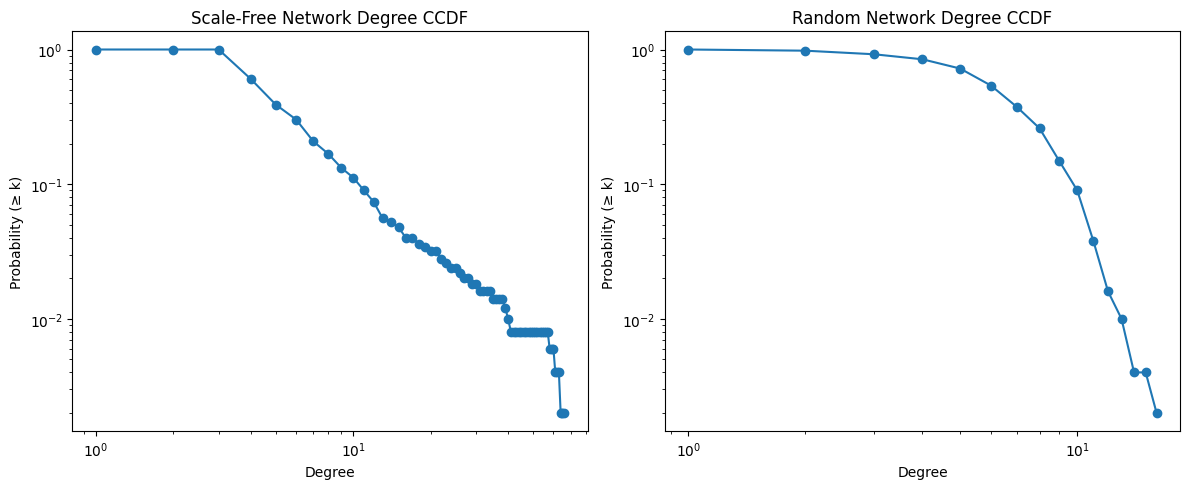

In [31]:
# Visualize degree distributions using CCDF in log-log scale

plt.figure(figsize=(12, 5))

# Scale-free network CCDF
plt.subplot(1, 2, 1)
degrees_sf = np.array([d for _, d in sf_network.degree()])
# Avoid k=0 for logarithmic scale
k_sf = np.arange(1, degrees_sf.max() + 1)
ccdf_sf = np.array([np.sum(degrees_sf >= k) / len(degrees_sf) for k in k_sf])
plt.plot(k_sf, ccdf_sf, marker='o', linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.title('Scale-Free Network Degree CCDF')
plt.xlabel('Degree')
plt.ylabel('Probability (≥ k)')

# Random network CCDF
plt.subplot(1, 2, 2)
degrees_er = np.array([d for _, d in er_network.degree()])
# Avoid k=0 for logarithmic scale
k_er = np.arange(1, degrees_er.max() + 1)
ccdf_er = np.array([np.sum(degrees_er >= k) / len(degrees_er) for k in k_er])
plt.plot(k_er, ccdf_er, marker='o', linestyle='-')
plt.xscale('log')
plt.yscale('log')
plt.title('Random Network Degree CCDF')
plt.xlabel('Degree')
plt.ylabel('Probability (≥ k)')

plt.tight_layout()
plt.show()

In [32]:
# Run attack simulations on both networks
removal_fraction = 0.8  # Remove up to 80% of nodes
steps = 40  # Number of measurement points

# Simulate random failures on both networks
sf_rand_x, sf_rand_y = simulate_network_attack(sf_network, attack_type='random', 
                                              removal_fraction=removal_fraction, steps=steps)
er_rand_x, er_rand_y = simulate_network_attack(er_network, attack_type='random', 
                                              removal_fraction=removal_fraction, steps=steps)

# Simulate targeted attacks on both networks
sf_targ_x, sf_targ_y = simulate_network_attack(sf_network, attack_type='targeted', 
                                              removal_fraction=removal_fraction, steps=steps)
er_targ_x, er_targ_y = simulate_network_attack(er_network, attack_type='targeted', 
                                              removal_fraction=removal_fraction, steps=steps)

### Visualizing Network Degradation Under Random Failure

The plot below shows how the network's giant component (largest connected component) shrinks as nodes are randomly removed. This visualization helps us understand the network's resilience to random failures.

- The x-axis represents the cumulative number of nodes removed
- The y-axis shows the proportion of nodes remaining in the giant component
- A gradual decline indicates robustness against random failures

In [33]:
# Calculate critical points (where giant component drops below 10% of original size)
def find_critical_point(x, y, threshold=0.1):
    for i, value in enumerate(y):
        if value <= threshold:
            return x[i]
    return 1.0  # If threshold never reached

critical_points = {
    'Scale-Free Random': find_critical_point(sf_rand_x, sf_rand_y),
    'Scale-Free Targeted': find_critical_point(sf_targ_x, sf_targ_y),
    'Random Network Random': find_critical_point(er_rand_x, er_rand_y),
    'Random Network Targeted': find_critical_point(er_targ_x, er_targ_y)
}

print("\nCritical removal fraction (where giant component falls below 10%):")
for network, point in critical_points.items():
    print(f"{network}: {point:.3f}")


Critical removal fraction (where giant component falls below 10%):
Scale-Free Random: 0.800
Scale-Free Targeted: 0.260
Random Network Random: 0.760
Random Network Targeted: 0.420


### Direct Comparison: Scale-Free vs. Random Network Robustness

The plot below provides a side-by-side comparison of how scale-free and random networks respond to both types of attacks. This direct comparison highlights the fundamental differences in vulnerability profiles between these network topologies:

- **Blue lines (Scale-Free Networks)**: Note the stark contrast between random failures (circles) and targeted attacks (triangles)
- **Red lines (Random Networks)**: Observe the more similar response patterns to both attack types
- **Shape comparison**: The difference between solid (random failure) and dashed (targeted attack) lines is much more dramatic for scale-free networks than for random networks

This visualization captures the essence of the "robust-yet-fragile" property of scale-free networks versus the more balanced vulnerability profile of random networks.

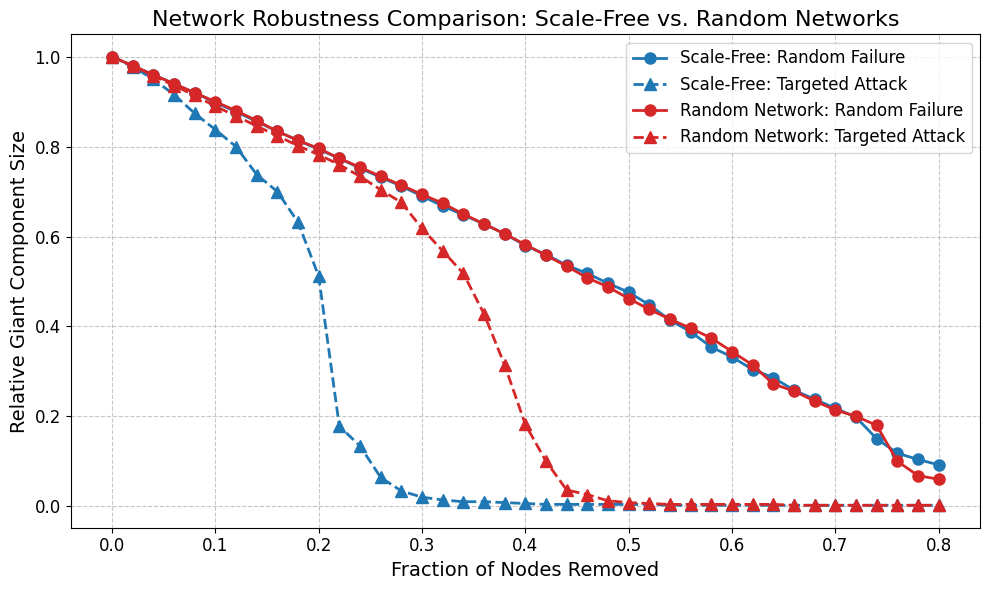

In [34]:
plt.figure(figsize=(10, 6))

plt.plot(sf_rand_x, sf_rand_y, marker='o', color='#1f77b4', linestyle='-', label='Scale-Free: Random Failure',
         linewidth=2, markersize=8)
plt.plot(sf_targ_x, sf_targ_y, marker='^', color='#1f77b4', linestyle='--', label='Scale-Free: Targeted Attack',
         linewidth=2, markersize=8)
plt.plot(er_rand_x, er_rand_y, marker='o', color='#d62728', linestyle='-', label='Random Network: Random Failure',
         linewidth=2, markersize=8)
plt.plot(er_targ_x, er_targ_y, marker='^', color='#d62728', linestyle='--', label='Random Network: Targeted Attack',
         linewidth=2, markersize=8)

plt.xlabel('Fraction of Nodes Removed', fontsize=14)
plt.ylabel('Relative Giant Component Size', fontsize=14)
plt.title('Network Robustness Comparison: Scale-Free vs. Random Networks', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

## Comprehensive Analysis of Network Robustness

Our simulations provide insights into how different network topologies respond to failures and attacks. Let's analyze key observations, theoretical underpinnings, and practical implications.

### Key Observations

1. **Scale-Free Networks Under Random Failure**
   - Maintain connectivity well when nodes fail randomly
   - Giant component size decreases gradually
   - Can sustain a high percentage of random node failures before critical fragmentation

2. **Scale-Free Networks Under Targeted Attack**
   - Collapse quickly when high-degree nodes (hubs) are targeted
   - Giant component size decreases sharply after removing a small fraction of nodes
   - Demonstrates extreme vulnerability to strategic attacks

3. **Random Networks Under Random Failure**
   - Show a predictable, often sigmoid-like degradation pattern
   - Fragment rapidly after a critical threshold is reached
   - Aligns with percolation theory predictions for Erdős–Rényi graphs

4. **Random Networks Under Targeted Attack**
   - Degrade under targeted attacks, but less dramatically than scale-free networks
   - Degradation curve is steeper than random failure but not as catastrophic as in scale-free networks

### Theoretical Explanation

1. **Scale-Free Networks Robust to Random Failures**
   - Most nodes have low degree; random removal mostly affects these nodes
   - Probability of randomly selecting a hub is low
   - Scale-free networks with degree exponent γ < 3 have no percolation threshold for random failures

2. **Scale-Free Networks Vulnerable to Targeted Attacks**
   - Hubs hold the network together; removing them dismantles the network's backbone
   - Power-law degree distribution creates structural vulnerability

3. **Random Networks Show Balanced Vulnerability**
   - Homogeneous degree distribution means most nodes have similar importance
   - Less structural difference between random and targeted node removal
   - Follow classic percolation theory with a predictable phase transition

### Practical Implications

1. **Infrastructure Design and Protection**
   - Critical infrastructure with scale-free properties should protect hub nodes
   - Redundancy in hub connections improves robustness against targeted attacks
   - Hybrid network designs may offer balanced robustness profiles

2. **Epidemic Control Strategies**
   - Targeted vaccination of "super-spreaders" is more effective than random vaccination

3. **Information and Influence Networks**
   - Targeted removal of influential nodes can disrupt information flow
   - Preserving key nodes is essential for maintaining communication during crises

4. **Biological Systems**
   - Many biological networks show scale-free properties with mechanisms to mitigate hub vulnerability
   - Functional redundancy and modular organization provide additional robustness

### Advanced Analysis Methods

1. **Advanced Metrics**
   - **Diameter increase**: Network's diameter growth as nodes are removed
   - **Efficiency decrease**: Increase in average shortest path length
   - **Percolation threshold**: Critical fraction of nodes that need to be removed before network collapse

2. **Methodological Considerations**
   - **Network Size Effects**: Robustness properties may scale differently in large networks
   - **Dynamic Adaptation**: Real networks often adapt to damage
   - **Beyond Binary Failure**: Real systems experience partial node or edge failures
   - **Edge Attacks**: Targeting connections presents different vulnerability patterns

Understanding network topology is crucial for designing resilient systems and predicting complex network behavior under stress.
